# Финальное задание курса

В итоговом задании курса мы предлагаем вам решить задачу регрессии - по характеристикам поездок на такси в Нью-Йорке научиться определять их стоимость.

В задании две части:

- первая часть - обычная. Так устроены все ноутбуки с домашними заданиями в курсе. Мы что-то просим - вы делаете. Задания этой части как обычно проверяются тестами на Stepik

- вторая часть - творческая. В этой части мы даем вам лишь идеи того, что можно сделать, а все остальное - на вас. Это задание проверяется в виде текстового отчета (подробности смотрите в описании второй части задания)


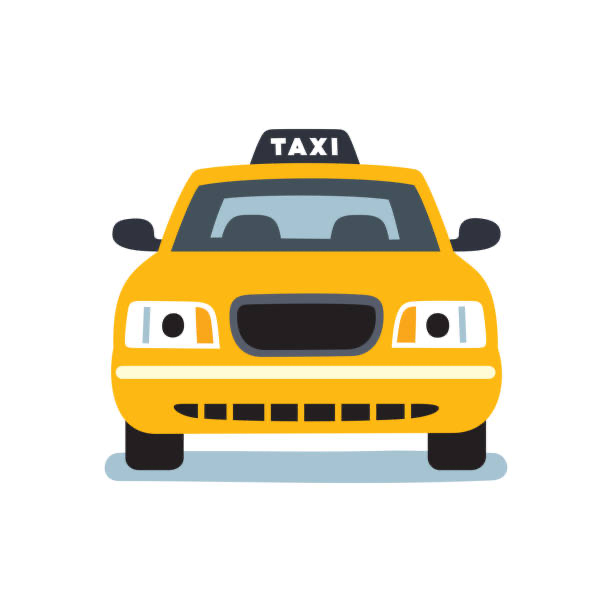


# Часть 1


In [58]:
import warnings
from pathlib import Path

import catboost
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from category_encoders import TargetEncoder
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

sklearn.set_config(transform_output="pandas")
sns.set_theme()
warnings.filterwarnings("ignore", message="Downcasting object dtype array*")

Прочитаем данные


In [59]:
PROJECT_DIR = Path(".").resolve().parent

DATA_DIR = PROJECT_DIR / "data"
FILE_NAME = "final_project_data.csv"

if not (DATA_DIR / FILE_NAME).exists():
    if not DATA_DIR.exists():
        DATA_DIR.mkdir()
    df = pd.read_csv(
        "https://www.dropbox.com/s/glmbcyopi24m2ni/final_project_data.csv?dl=1"
    )
    df.to_csv(DATA_DIR / FILE_NAME, index=False)
else:
    df = pd.read_csv(DATA_DIR / FILE_NAME)

df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2011-11-23 14:36:35.0000003,2011-11-23 14:36:35 UTC,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5
1,2013-09-14 21:40:00.00000016,2013-09-14 21:40:00 UTC,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5
2,2012-04-30 18:13:19.0000002,2012-04-30 18:13:19 UTC,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5
3,2010-10-22 15:03:47.0000001,2010-10-22 15:03:47 UTC,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5
4,2011-02-18 18:08:16.0000002,2011-02-18 18:08:16 UTC,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1


## Исследование данных


### Quiz

Сколько строк в таблице df?


In [3]:
# ваш код здесь
df.shape

(615962, 8)

### Quiz

Есть ли пропущенные значения в таблице? В скольких столбцах есть пропуски?


In [4]:
# ваш код здесь
df.isna().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      1
dropoff_longitude    3
dropoff_latitude     3
passenger_count      1
fare_amount          1
dtype: int64

### Quiz

Удалите строки с пропущенными значениями из таблицы. Сколько строк осталось в таблице?


In [ ]:
# ваш код здесь
df = df.dropna()

In [6]:
df.shape

(615959, 8)

Удалите из данных колонку `key`, так как в ней дублируется информация из `pickup_datetime`


In [ ]:
# ваш код здесь
df = df.drop(["key"], axis=1)

Обработайте колонку `pickup_datetime`. Выделите из нее 4 новых столбца:

- `year` - год поездки
- `month` - месяц поездки
- `day` - день поездки
- `hour` - час поездки. Час вычисляйте так: если до следующего часа осталось меньше 30 минут (на секунды не смотрим), что час округляете до следующего.

Пример: 14:18:20 -> 14 часов, 17:48:29 -> 18 часов

Затем удалите столбец `pickup_datetime`.


In [8]:
# ваш код здесь
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"]).dt.round(freq="h")
df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["day"] = df["pickup_datetime"].dt.day
df["hour"] = df["pickup_datetime"].dt.hour

df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
0,2011-11-23 15:00:00+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15
1,2013-09-14 22:00:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22
2,2012-04-30 18:00:00+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18
3,2010-10-22 15:00:00+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15
4,2011-02-18 18:00:00+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18


## Вопросы по данным


### Quiz

В какие годы совершались поездки?


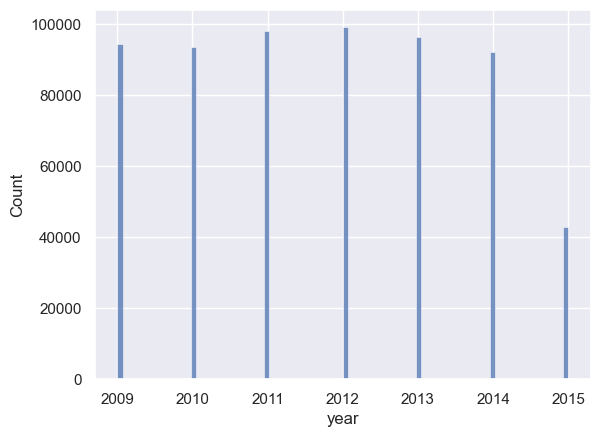

In [9]:
# ваш код здесь
sns.histplot(df, x="year")
plt.show()

### Quiz

В какой час было совершено больше всего поездок?


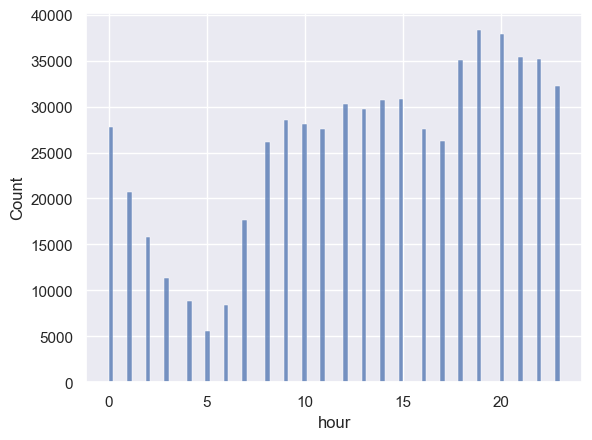

In [10]:
# ваш код здесь
sns.histplot(df, x="hour")
plt.show()

In [11]:
df["hour"].value_counts()

hour
19    38307
20    37865
21    35417
22    35220
18    35090
23    32240
15    30829
14    30749
12    30277
13    29774
9     28580
10    28078
0     27764
11    27590
16    27554
17    26271
8     26154
1     20670
7     17606
2     15787
3     11309
4      8867
6      8392
5      5569
Name: count, dtype: int64

### Quiz

В какой сезон (зима, весна, лето, осень) было совершено наименьшее число поездок?


In [12]:
# ваш код здесь
seasons = {
    1: "winter",
    2: "winter",
    3: "spring",
    4: "spring",
    5: "spring",
    6: "summer",
    7: "summer",
    8: "summer",
    9: "autumn",
    10: "autumn",
    11: "autumn",
    12: "winter",
}
df["month"].map(seasons).value_counts()

month
spring    172257
winter    153952
summer    146385
autumn    143365
Name: count, dtype: int64

Постройте scatter plot в осях `pickup_latitude` и `pickup_longitude`


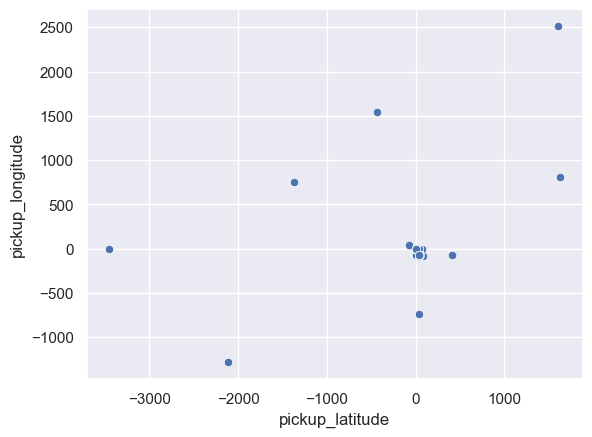

In [13]:
# ваш код здесь
sns.scatterplot(df, x="pickup_latitude", y="pickup_longitude")
plt.show()

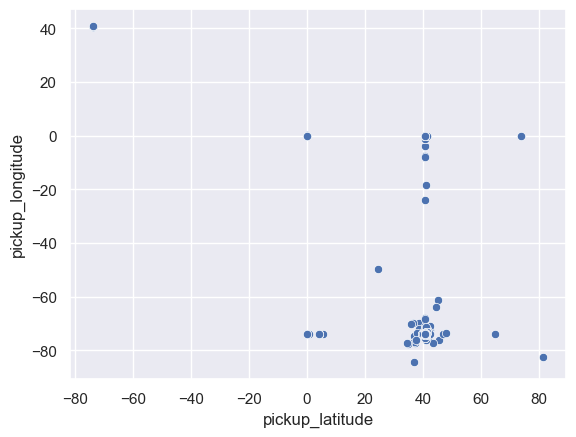

In [14]:
sns.scatterplot(
    df[
        df["pickup_latitude"].between(-90, 90)
        & df["pickup_longitude"].between(-180, 180)
    ],
    x="pickup_latitude",
    y="pickup_longitude",
)
plt.show()

### Quiz

Постройте ящик с усами boxplot для `pickup_longitude`. Есть ли на визуализации выбросы? (отдельные точки)


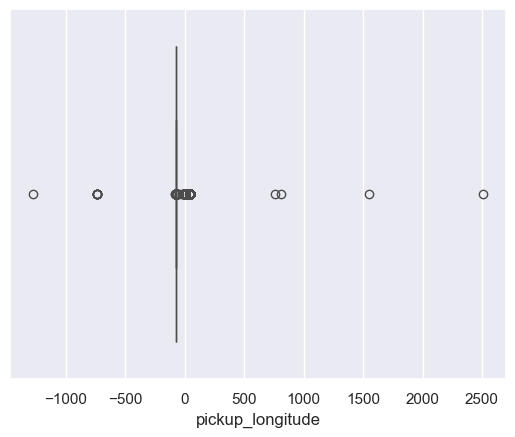

In [15]:
# ваш код здесь
sns.boxplot(df, x="pickup_longitude")
plt.show()

### Quiz

Чему равна медиана `pickup_longitude`? Ответ округлите до тысячных.


In [16]:
# ваш код здесь
df["pickup_longitude"].median().__round__(3)

-73.982

Постройте гистограмму распределения признака `hour`.


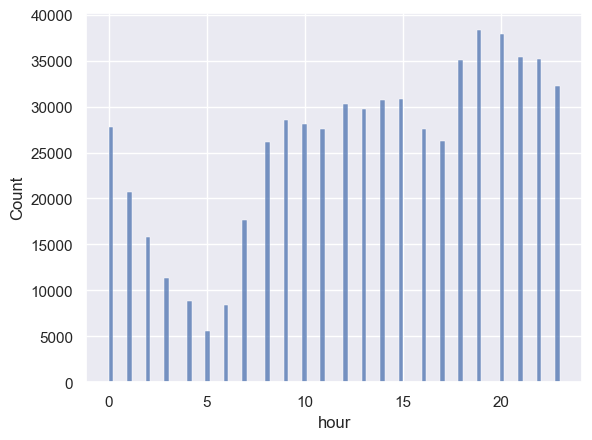

In [17]:
# ваш код здесь
sns.histplot(df, x="hour")
plt.show()

## Построение baseline-модели


Разбейте `df` на матрицу объект-признак `X` и вектор с целевой переменной `y`. Целевая переменная - столбец `fare_amount`.


In [ ]:
# ваш код здесь
X = df.drop(["fare_amount", "pickup_datetime"], axis=1).copy()
y = df["fare_amount"].copy()

Разбейте данные на тренировочную и тестовую части с помощью train_test_split.

Тестовая часть - 25% всех данных, `random_state=42`.

Сколько строк в матрице `X_train`?


In [19]:
# ваш код здесь
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_train.shape

(461969, 9)

### Quiz

Обучите решающее дерево глубины 3 на тренировочных данных и вычислите ошибку $R^2$ на тесте. Ответ округлите до сотых.

Зафиксируйте у дерева `random_state=42`.


In [20]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

# ваш код здесь
d3_model = DecisionTreeRegressor(max_depth=3, random_state=42)
d3_model.fit(X_train, y_train)
y_pred = d3_model.predict(X_test)

print("R2:", round(r2_score(y_pred=y_pred, y_true=y_test), 2))

R2: 0.5


### Quiz

Постройте гистограмму важности признаков.

Какой признак имеет наибольший вес?


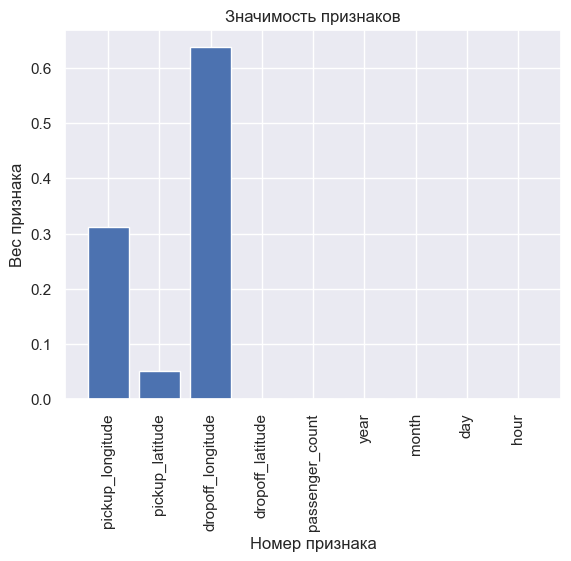

In [21]:
# ваш код здесь
plt.title("Значимость признаков")
plt.bar(X_train.columns, d3_model.feature_importances_)
plt.xlabel("Номер признака")
plt.xticks(rotation=90)
plt.ylabel("Вес признака")

plt.show()

## Улучшение модели


### Quiz

Постройте гистограмму распределения целевой переменной `y`, укажите параметр `bins=100`.

Является ли распределение нормальным?


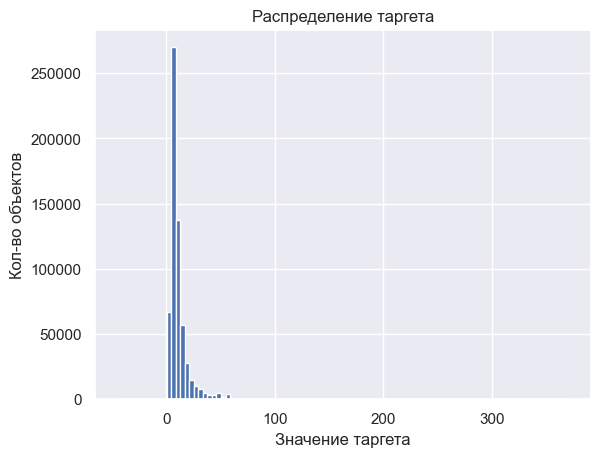

In [22]:
# ваш код здесь
plt.title("Распределение таргета")
plt.hist(y, bins=100)
plt.xlabel("Значение таргета")
plt.ylabel("Кол-во объектов")
plt.show()

Замените все значения $y$, меньшие 0, на 0.

Сделайте преобразование целевой переменной по правилу $y_{new} = np.log1p(y)$

Заново разбейте данные на тренировочную и тестовую часть по тем же правилам, что и раньше, но теперь используйте `X` и `y_new`.


In [ ]:
# ваш код здесь
y_new = np.log1p(y.clip(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_new, test_size=0.25, random_state=42
)

### Quiz

Заново обучите решающее дерево глубины 3 с `random_state=42` на тренировочных данных и вычислите $R^2$ на тесте. Ответ округлите до сотых.

Перед вычислением $R^2$ сделайте обратное преобразование от прогноза: `np.expm1(pred)` и от `y_test`.

**Важно:** дальше мы будем работать с преобразованной целевой переменной, поэтому при вычислении $R^2$ во всех заданиях ниже делайте обратное преобразование.


In [25]:
# ваш код здесь
d3_model = DecisionTreeRegressor(max_depth=3, random_state=42)
d3_model.fit(X_train, y_train)
y_pred = d3_model.predict(X_test)

print("R2:", round(r2_score(y_true=np.expm1(y_test), y_pred=np.expm1(y_pred)), 2))

R2: 0.44


### Quiz

Подберите по кросс-валидации на тренировочных данных глубину дерева в диапазоне от 3 до 10 включительно с шагом 1 (`random_state=42`).

`cv=3, scoring=r2`

Затем примените модель с оптимальной глубиной на тесте и вычислите $R^2$. Ответ округлите до сотых.

Перед вычислением $R^2$ не забудьте (как и дальше) делать преобразование `np.expm1`


In [ ]:
from sklearn.metrics import make_scorer


def r2_expm1_score(y_true, y_pred):
    y_true = np.expm1(y_true)
    y_pred = np.expm1(y_pred)
    return r2_score(y_true=y_true, y_pred=y_pred)


r2_expm1_scorer = make_scorer(r2_expm1_score, greater_is_better=True)

In [27]:
# ваш код здесь
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": range(3, 11)}
grid_cv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring=r2_expm1_scorer,
    cv=3,
    n_jobs=-1,
)

grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 11)},
             scoring=make_scorer(r2_expm1_score, response_method='predict'))

In [28]:
grid_cv.best_params_

{'max_depth': 10}

In [29]:
d3_model = DecisionTreeRegressor(**grid_cv.best_params_, random_state=42)
d3_model.fit(X_train, y_train)
y_pred = d3_model.predict(X_test)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.68


## Усложнение пайплайна


Создайте pipeline, в котором сначала извлеките полиномиальные признаки степени 2 из данных, а затем обучите решающее дерево глубины 3 с `random_state=42`.


### Quiz

Обучите pipeline на тренировочных данных, сделайте прогноз на тесте и вычислите $R^2$. Ответ округлите до сотых.


In [30]:
# ваш код здесь
p1 = Pipeline(
    [
        ("features", PolynomialFeatures(degree=2)),
        ("model", DecisionTreeRegressor(random_state=42)),
    ]
)

p1.fit(X_train, y_train)
y_pred = p1.predict(X_test)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.56


При помощи GridSearchCV с теми же гиперпараметрами, что и раньше, подберите глубину дерева внутри пайплайна в диапазоне от 3 до 10 включительно с шагом 1.


In [31]:
# ваш код здесь
p2 = Pipeline(
    [
        ("features", PolynomialFeatures(degree=2)),
        ("model", DecisionTreeRegressor(random_state=42)),
    ]
)
params = {"model__max_depth": range(3, 11)}

grid_cv = GridSearchCV(p2, param_grid=params, cv=3, scoring=r2_expm1_scorer, n_jobs=-1)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features', PolynomialFeatures()),
                                       ('model',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1, param_grid={'model__max_depth': range(3, 11)},
             scoring=make_scorer(r2_expm1_score, response_method='predict'))

In [32]:
grid_cv.best_params_

{'model__max_depth': 10}

### Quiz

Выведите $R^2$ лучшего результата на тесте. Ответ округлите до сотых.


In [33]:
# ваш код здесь
p2 = Pipeline(
    [
        ("features", PolynomialFeatures(degree=2)),
        ("model", DecisionTreeRegressor(max_depth=10, random_state=42)),
    ]
)
p2.fit(X_train, y_train)
y_pred = p2.predict(X_test)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.71


## Feature selection


Добавьте в предыдущий пайплайн:

- после добавления полиномиальных признаков - StandardScaler
- затем - снижение размерности при помощи метода `SelectFromModel` с моделью `Ridge` с гиперпараметрами по умолчанию.


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# ваш код здесь
p3 = Pipeline(
    steps=[
        ("poly_features", PolynomialFeatures(degree=2)),
        ("std_scaler", StandardScaler().set_output(transform="pandas")),
        ("reducer", SelectFromModel(Ridge())),
        ("model", DecisionTreeRegressor(max_depth=10, random_state=42)),
    ]
)

Обучите пайплайн на тренировочных данных, сделайте прогноз на тесте и вычислите для него $R^2$.


In [35]:
# ваш код здесь
p3.fit(X_train, y_train)
y_pred = p3.predict(X_test)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.67


Подберите глубину решающего дерева в пайплайне, в том же диапазоне и теми же гиперпараметрами GridSearch, что и в предыдущих заданиях.

Вычислите $R^2$ на тестовых данных, ответ округлите до сотых.


### Quiz

Удалось ли при помощи пайплайна с отбором признаков улучшить результат предыдущей лучшей модели?


## Кодирование категориальных признаков


Признаки `month`, `day`, `hour` - категориальные (подумайте почему!)

Поэтому их можно попробовать закодировать.

Попробуем подход: группировка значений признака + дальнейшая OneHot-кодировка.

- Создайте колонки `winter`, `spring`, `summer`, `autumn` - в каждую из которых пишите 1, если месяц относится к сезону, и 0 иначе.

- Создайте колонки `start_month`, `middle_month`, `end_month` - в каждую колонку пишите 1, если день относится к началу месяца (1-10 число), середине месяца (11-20 число), концу месяца (от 21 числа), и 0 иначе.

- Создайте колонки `night`, `morning`, `day`, `evening` по аналогии. Если час - от 23 до 5, то это `night`, от 6 до 11 - `morning`, от 12 до 16 - `day`, от 17 до 22 - `evening`.

После создания новых колонок удалите колонки `month`, `day`, `hour`.

P.S. Отдельно делайте преобразования для X_train и для X_test, чтобы заново не разбивать данные.


In [36]:
# ваш код здесь
def encode_categorial(df: pd.DataFrame, get_dummies: bool = True):
    df = df.copy()

    def encode_month(x):
        if x < 11:
            return "start_month"
        elif 11 <= x <= 20:
            return "middle_month"
        elif x > 20:
            return "end_month"
        return "unknown_month_part"

    def encode_day_part(x):
        if x == 23 or x < 6:
            return "night"
        elif 6 <= x <= 11:
            return "morning"
        elif 12 <= x <= 16:
            return "day"
        elif 17 <= x <= 22:
            return "evening"
        return "unknown_day_part"

    df["season"] = df["month"].map(seasons)
    df["month_part"] = df["day"].map(encode_month)
    df["day_part"] = df["hour"].map(encode_day_part)
    if get_dummies:
        df = pd.get_dummies(df, prefix="", prefix_sep="_")

    df = df.drop(
        ["_unknown_day_part", "_unknown_month_part", "hour", "day", "month"],
        axis=1,
        errors="ignore",
    )
    df.columns = [c if c[0] != "_" else c[1:] for c in df.columns]
    return df


X_train_cat = encode_categorial(X_train)
X_test_cat = encode_categorial(X_test)
X_train_cat.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,autumn,spring,summer,winter,end_month,middle_month,start_month,day,evening,morning,night
537483,-73.984460,40.720162,-73.984322,40.731110,1.0,2011,True,False,False,False,False,False,True,False,True,False,False
543146,-73.937375,40.804540,-73.960572,40.807480,2.0,2013,False,True,False,False,False,True,False,False,True,False,False
575883,-73.925792,40.744198,-73.918459,40.765595,1.0,2010,False,False,False,True,True,False,False,False,False,True,False
66928,-74.003342,40.722141,-74.015869,40.715488,5.0,2015,False,False,False,True,False,True,False,False,False,True,False
164891,-73.991783,40.749656,-73.979164,40.740610,1.0,2011,True,False,False,False,True,False,False,True,False,False,False


### Quiz

На сколько признаков стало больше в матрице-объект признак после добавления закодированных категориальных столбцов и удаления исходных категориальных столбцов?


In [37]:
X_train_cat.shape[1] - X_train.shape[1]

8

Подберите при помощи GridSearch с теми же гиперпараметрами, что и выше, оптимальную глубину дерева в диапазоне от 3 до 10 включительно (с шагом 1). У дерева `random_state=42`.


In [38]:
# ваш код здесь
grid_cv = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    {"max_depth": range(3, 10)},
    cv=3,
    scoring=r2_expm1_scorer,
    n_jobs=-1,
)
grid_cv.fit(X_train_cat, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(3, 10)},
             scoring=make_scorer(r2_expm1_score, response_method='predict'))

Постройте гистограмму важности признаков для полученной модели (лучшей по GridSearch).


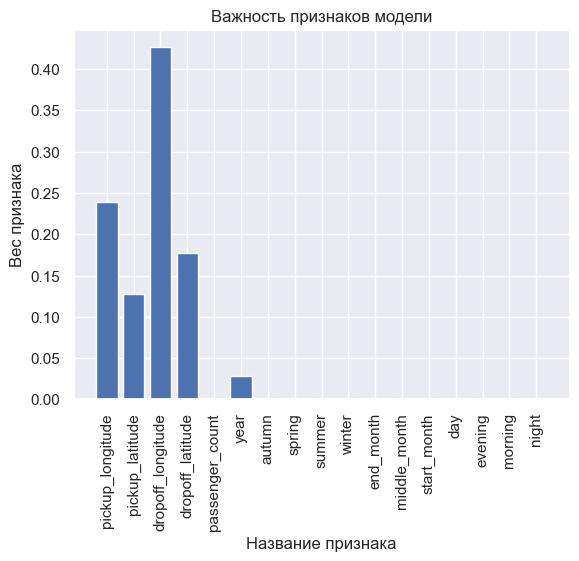

In [39]:
# ваш код здесь
plt.title("Важность признаков модели")
plt.bar(X_train_cat.columns, grid_cv.best_estimator_.feature_importances_)
plt.xlabel("Название признака")
plt.xticks(rotation=90)
plt.ylabel("Вес признака")
plt.show()

### Quiz

Какой из признаков, связанных с датой поездки, самый важный для модели?


In [40]:
"year"

'year'

Проверим качество модели с добавлением категориальных параметров


In [41]:
d3_model_cat = DecisionTreeRegressor(max_depth=10, random_state=42)
d3_model_cat.fit(X_train_cat, y_train)
y_pred = d3_model_cat.predict(X_test_cat)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.69


Обучим пайплайн на категориальных данных


In [42]:
p4 = Pipeline(
    steps=[
        ("poly_features", PolynomialFeatures(degree=2)),
        ("std_scaler", StandardScaler().set_output(transform="pandas")),
        # ("reducer", SelectFromModel(Ridge())),
        ("model", DecisionTreeRegressor(max_depth=10, random_state=42)),
    ]
)

p4.fit(X_train_cat, y_train)
y_pred = p4.predict(X_test_cat)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.68


## Кластеризация и визуализация


Оставьте только те строчки в таблице df (после удаления пропусков), для которых выполнены оба условия:

- `dropoff_latitude` $\in (39;41)$
- `dropoff_longitude` $\in (-75;-72)$

### Quiz

Сколько строк осталось в таблице?


In [ ]:
# ваш код здесь
df_cluster = df[
    df["dropoff_latitude"].between(39, 41, inclusive="neither")
    & df["dropoff_longitude"].between(-75, -72, inclusive="neither")
]

Разбейте все поездки по признакам `dropoff_latitude`, `dropoff_longitude` на 5 кластеров.

Используйте kmeans c `random_state=42`.

Визуализируйте поездки из таблицы df в осях `dropoff_latitude`, `dropoff_longitude` - покрасьте точки в цвета, соответствующие кластерам.


In [44]:
# ваш код здесь
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=5, random_state=42)
df_cluster.loc[:, "cluster"] = kmeans_model.fit_predict(
    df_cluster.loc[:, ["dropoff_latitude", "dropoff_longitude"]]
)

/var/folders/rc/dz40hxw14yg8cgj4yn4n05700000gn/T/ipykernel_79868/2679947591.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster.loc[:, "cluster"] = kmeans_model.fit_predict(


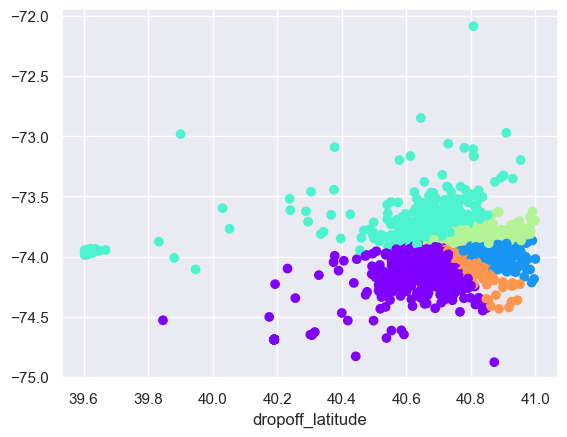

In [45]:
import matplotlib

plt.scatter(
    df_cluster["dropoff_latitude"],
    df_cluster["dropoff_longitude"],
    c=(df_cluster["cluster"] / kmeans_model.n_clusters).map(matplotlib.cm.rainbow),
)
plt.xlabel("dropoff_longitude")
plt.xlabel("dropoff_latitude")
plt.show()

### Quiz

Для каждого кластера вычислите среднюю стоимость поездки.

Чему равна самая большая средняя стоимость поездки по кластерам? Ответ округлите до целого числа.


In [46]:
# ваш код здесь
df_cluster.groupby("cluster")["fare_amount"].mean().round()

cluster
0    13.0
1    10.0
2    40.0
3    24.0
4    10.0
Name: fare_amount, dtype: float64

Отдельно нарисуйте кластер с наибольшей средней стоимостью поездки. В нем выделяется два островка.


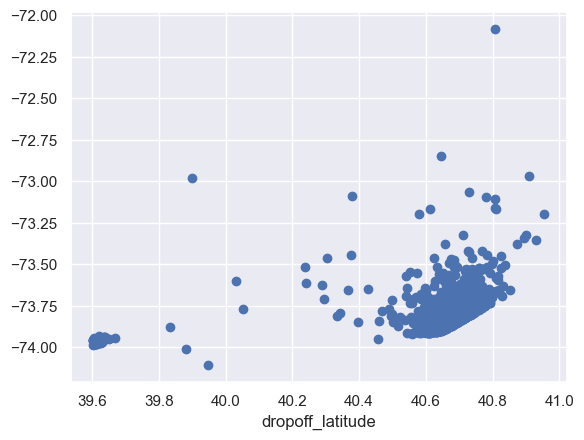

In [47]:
# ваш код здесь
df_cluster_2 = df_cluster[df_cluster["cluster"] == 2]

plt.scatter(
    df_cluster_2["dropoff_latitude"],
    df_cluster_2["dropoff_longitude"],
)
plt.xlabel("dropoff_longitude")
plt.xlabel("dropoff_latitude")
plt.show()

### Quiz

Кластеризуйте точки этого кластера при помощи DBSCAN с гиперпараметрами `eps`=0.15, `min_samples`=10.

Нарисуйте результат.

Вычислите координаты центра (среднее арифметрическое) меньшего кластера.

В ответе укажите `dropoff_latitude`, округленную до тысячных.


In [48]:
# ваш код здесь
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=0.15, min_samples=10, n_jobs=-1)
df_cluster_2.loc[:, "cluster"] = dbscan_model.fit_predict(
    df_cluster_2.loc[:, ["dropoff_latitude", "dropoff_longitude"]]
)

/var/folders/rc/dz40hxw14yg8cgj4yn4n05700000gn/T/ipykernel_79868/2832958328.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_cluster_2.loc[:, "cluster"] = dbscan_model.fit_predict(


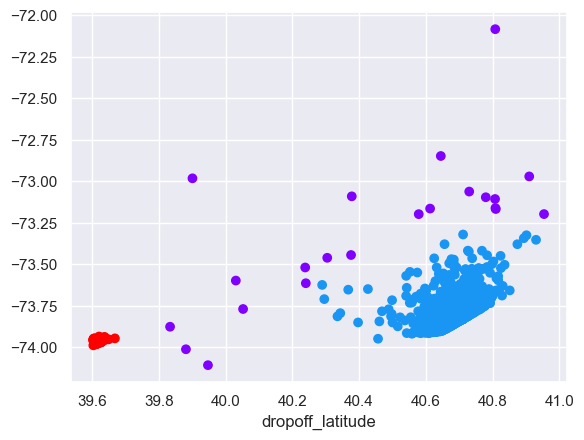

In [49]:
plt.scatter(
    df_cluster_2["dropoff_latitude"],
    df_cluster_2["dropoff_longitude"],
    c=(df_cluster_2["cluster"] + 1 / kmeans_model.n_clusters).map(
        matplotlib.cm.rainbow
    ),
)
plt.xlabel("dropoff_longitude")
plt.xlabel("dropoff_latitude")
plt.show()

In [50]:
df_cluster_2["cluster"].value_counts()

cluster
 0    6952
 1      57
-1      22
Name: count, dtype: int64

In [51]:
df_cluster_2.groupby("cluster")[["dropoff_latitude", "dropoff_longitude"]].mean().round(
    3
)

,dropoff_latitude,dropoff_longitude
cluster,,
-1,40.437,-73.296
0,40.661,-73.786
1,39.616,-73.961


# Часть 2

## Творческая (но обязательная) часть


В работе мы построили baseline-модель, потом попытались ее улучшить, усложнив пайплайн увеличением, а затем снижением размерности. Но попробовали мы лишь малую часть из всех возможных подходов, а также всего лишь одну модель - решающее дерево.

В этой части задания вам предлагается не ограничивать себя идеями, попробованными выше:

- придумывайте новые признаки
- пробуйте разные кодировки признаков
- снижайте размерность и делайте отбор признаков
- пробуйте разные модели
- комбинируйте подходы

У вас есть знания целого курса для работы над задачей, ни в чем вас не ограничиваем!

Ваша цель - построить модель, дающую наилучший скор $R^2$ на тестовых данных (с фиксированным разбиением на train-test, указанным в коде ноутбука выше).


## Обработка выбросов


Посмотрим на описательную статистику по координатам:


In [52]:
df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
count,615959.000000,615959.000000,615959.000000,615959.000000,615959.000000,615959.000000,615959.000000,615959.000000,615959.000000,615959.000000
mean,-72.528287,39.932560,-72.531908,39.917904,1.685127,11.332180,2011.741126,6.263553,15.705256,13.444804
std,11.517516,8.754114,11.829973,10.339851,1.309251,9.743292,1.859415,3.434809,8.684390,6.680492
min,-1280.547368,-3447.915090,-3328.756240,-3493.651853,0.000000,-45.000000,2009.000000,1.000000,1.000000,0.000000
25%,-73.992078,40.735004,-73.991380,40.734070,1.000000,6.000000,2010.000000,3.000000,8.000000,9.000000
50%,-73.981803,40.752714,-73.980167,40.753212,1.000000,8.500000,2012.000000,6.000000,16.000000,14.000000
75%,-73.967087,40.767184,-73.963688,40.768120,2.000000,12.500000,2013.000000,9.000000,23.000000,19.000000
max,2512.533050,1629.004200,2058.322398,1640.072227,6.000000,370.000000,2015.000000,12.000000,31.000000,23.000000


### Очистка выбросов по координатам


Координаты, измеряемые в градусах должны принимать значения:

- Широта: -90 до 90
- Долгота: -180 до 180

Посмотрим в отдельности на выбросы, по каждой из координат

Широта откуда забрали клиента:


In [53]:
df[(df["pickup_latitude"] < -90) | (df["pickup_latitude"] > 90)].shape

(12, 11)

Долгота откуда забрали клиента:


In [54]:
df[(df["pickup_longitude"] < -180) | (df["pickup_longitude"] > 180)].shape

(13, 11)

Широта точки назначения:


In [55]:
df[(df["dropoff_latitude"] < -90) | (df["dropoff_latitude"] > 90)].shape

(13, 11)

Долгота точки назначения:


In [56]:
df[(df["dropoff_longitude"] < -180) | (df["dropoff_longitude"] > 180)].shape

(8, 11)

Общее кол-во выбросов невелико, избавимся от них


In [57]:
df_clear = df[
    df["pickup_latitude"].between(-90, 90)
    & df["pickup_longitude"].between(-180, 180)
    & df["dropoff_latitude"].between(-90, 90)
    & df["dropoff_longitude"].between(-180, 180)
].copy()
print(
    "Осталось строк:",
    df_clear.shape[0],
    "Убрано выбросов:",
    df.shape[0] - df_clear.shape[0],
)

Осталось строк: 615927 Убрано выбросов: 32


Проверим датасет на наличие поездок с одинаковыми точками отправления и назначения


In [58]:
df_out_same_point = df_clear[
    (df_clear["pickup_latitude"] == df_clear["dropoff_latitude"])
    & (df_clear["pickup_longitude"] == df_clear["dropoff_longitude"])
]
df_out_same_point

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
41,2010-07-07 10:00:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,8.9,2010,7,7,10
50,2011-01-10 00:00:00+00:00,-73.983628,40.729242,-73.983628,40.729242,1.0,13.3,2011,1,10,0
104,2012-05-18 15:00:00+00:00,-73.968485,40.767382,-73.968485,40.767382,1.0,8.5,2012,5,18,15
121,2012-02-27 20:00:00+00:00,0.000000,0.000000,0.000000,0.000000,2.0,6.1,2012,2,27,20
193,2014-07-20 17:00:00+00:00,0.000000,0.000000,0.000000,0.000000,5.0,12.5,2014,7,20,17
...,...,...,...,...,...,...,...,...,...,...,...
615900,2011-06-04 15:00:00+00:00,-73.956627,40.812552,-73.956627,40.812552,5.0,5.7,2011,6,4,15
615908,2011-03-11 21:00:00+00:00,0.000000,0.000000,0.000000,0.000000,2.0,11.3,2011,3,11,21
615924,2009-07-08 21:00:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,13.7,2009,7,8,21
615938,2010-03-20 12:00:00+00:00,0.000000,0.000000,0.000000,0.000000,5.0,7.7,2010,3,20,12


In [59]:
print(
    "% поездок с одинаковыми точками отправления и назначения:",
    round(df_out_same_point.shape[0] * 100 / df_clear.shape[0], 2),
)

% поездок с одинаковыми точками отправления и назначения: 2.82


Интересный момент, что у нас 3% поездок (от очищенных данных), у которых:

- Имеются нулевые координаты отправной точки и точки прибывания
- Поездки, у которых совпадают отправная точка и точка прибывания

Очистим данные от подобных поездок


In [60]:
df_clear = df_clear.drop(df_out_same_point.index, errors="ignore")
df_clear

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
0,2011-11-23 15:00:00+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15
1,2013-09-14 22:00:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22
2,2012-04-30 18:00:00+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18
3,2010-10-22 15:00:00+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15
4,2011-02-18 18:00:00+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18
...,...,...,...,...,...,...,...,...,...,...,...
615956,2013-12-01 00:00:00+00:00,-73.979049,40.736143,-73.980528,40.730353,1.0,5.5,2013,12,1,0
615957,2014-05-06 20:00:00+00:00,-73.976600,40.745290,-73.980242,40.759672,2.0,10.5,2014,5,6,20
615958,2012-01-31 00:00:00+00:00,-73.987750,40.745760,-73.953092,40.776787,1.0,10.9,2012,1,31,0
615959,2014-07-28 00:00:00+00:00,-73.983165,40.728207,-74.002797,40.728670,1.0,7.5,2014,7,28,0


Проверим отдельно координаты на наличие координат не соотвествующим порогу


In [61]:
COORD_THRESHOLD = 5
df_out_zero_coord = df_clear[
    (df_clear["pickup_latitude"].abs() < COORD_THRESHOLD)
    | (df_clear["pickup_longitude"].abs() < COORD_THRESHOLD)
    | (df_clear["dropoff_latitude"].abs() < COORD_THRESHOLD)
    | (df_clear["dropoff_longitude"].abs() < COORD_THRESHOLD)
]
df_out_zero_coord

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
593,2009-02-15 19:00:00+00:00,0.000000,0.000000,-73.960180,40.772188,1.0,11.3,2009,2,15,19
703,2011-04-30 16:00:00+00:00,0.000000,0.000000,-74.689831,40.190564,1.0,14.1,2011,4,30,16
1380,2013-11-10 01:00:00+00:00,-73.985590,40.747167,0.000000,0.000000,2.0,10.0,2013,11,10,1
1859,2012-11-04 16:00:00+00:00,-73.962875,40.799577,0.000000,0.000000,2.0,16.0,2012,11,4,16
1990,2014-01-20 09:00:00+00:00,-73.977001,40.743437,0.000000,0.000000,1.0,10.0,2014,1,20,9
...,...,...,...,...,...,...,...,...,...,...,...
614545,2010-06-12 20:00:00+00:00,0.002165,-0.001065,-0.001857,-0.008263,1.0,5.7,2010,6,12,20
614634,2014-07-06 05:00:00+00:00,0.000000,0.000000,-73.979800,40.666885,2.0,17.5,2014,7,6,5
614907,2014-07-28 00:00:00+00:00,-73.988424,40.759880,0.000000,0.000000,2.0,2.5,2014,7,28,0
615299,2012-06-23 23:00:00+00:00,-73.990333,40.757672,0.000000,0.000000,1.0,110.0,2012,6,23,23


Видим небольшое кол-во выбросов связанных с нулевыми координатами, данные можно удалить


In [62]:
df_clear = df_clear.drop(df_out_zero_coord.index, errors="ignore")
df_clear

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
0,2011-11-23 15:00:00+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15
1,2013-09-14 22:00:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22
2,2012-04-30 18:00:00+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18
3,2010-10-22 15:00:00+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15
4,2011-02-18 18:00:00+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18
...,...,...,...,...,...,...,...,...,...,...,...
615956,2013-12-01 00:00:00+00:00,-73.979049,40.736143,-73.980528,40.730353,1.0,5.5,2013,12,1,0
615957,2014-05-06 20:00:00+00:00,-73.976600,40.745290,-73.980242,40.759672,2.0,10.5,2014,5,6,20
615958,2012-01-31 00:00:00+00:00,-73.987750,40.745760,-73.953092,40.776787,1.0,10.9,2012,1,31,0
615959,2014-07-28 00:00:00+00:00,-73.983165,40.728207,-74.002797,40.728670,1.0,7.5,2014,7,28,0


### Очистка таргета


В таргете `fare_amount` - имеются отрицательные значения, чего быть не может, так как цена за поездку положительное число, либо ноль, проверим количество подобных поездок


In [63]:
df_out_target_less_zero = df_clear[df_clear["fare_amount"] < 0]

display(df_out_target_less_zero.head())
print("Кол-во выбросов:", df_out_target_less_zero.shape[0])

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
17263,2010-03-27 06:00:00+00:00,-73.988002,40.748412,-73.912038,40.745942,1.0,-17.3,2010,3,27,6
89241,2015-02-02 19:00:00+00:00,-73.984581,40.768642,-73.981674,40.766941,1.0,-3.0,2015,2,2,19
144928,2010-02-26 05:00:00+00:00,-73.974052,40.755310,-73.974053,40.755288,1.0,-45.0,2010,2,26,5
159729,2010-02-22 17:00:00+00:00,-73.985375,40.739503,-73.994073,40.751328,1.0,-5.7,2010,2,22,17
223115,2010-02-17 11:00:00+00:00,-73.976403,40.765072,-73.976210,40.764943,1.0,-2.5,2010,2,17,11


Кол-во выбросов: 19


Очистим данные от поездок с отрицательным платежом


In [64]:
df_clear = df_clear.drop(df_out_target_less_zero.index, errors="ignore")
df_clear.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour
0,2011-11-23 15:00:00+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15
1,2013-09-14 22:00:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22
2,2012-04-30 18:00:00+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18
3,2010-10-22 15:00:00+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15
4,2011-02-18 18:00:00+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18


## Обработка координат


Т.к. мы работаем с гео данными - давайте попробуем добавить фичу, которая отвечает за расстояние между точкой отправки и точкой назначения
Для начала используем евклидово расстояние


In [65]:
from typing import Callable

from pyproj import Transformer

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")


def haversine_distance(x1: pd.Series, x2: pd.Series, y1: pd.Series, y2: pd.Series):
    """
    Функция расчёта расстояния на сфере по координтам
    https://en.wikipedia.org/wiki/Haversine_formula
    """
    R = 6371
    lat1 = np.radians(x1)
    long1 = np.radians(x2)
    lat2 = np.radians(y1)
    long2 = np.radians(y2)

    dlat = lat2 - lat1
    dlong = long2 - long1

    a = np.sin(dlat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong * 0.5) ** 2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return c * R * 1000


def manhattan_distance(x1: pd.Series, x2: pd.Series, y1: pd.Series, y2: pd.Series):
    """
    Манхэттенское расстояние между двумя точками
    требует преобразования градусной системы координат в метрическую
    """
    return np.abs(y1 - x1) + np.abs(y2 - x2)


def euclidian_distance(x1: pd.Series, x2: pd.Series, y1: pd.Series, y2: pd.Series):
    """
    Евклидово расстояние между двумя точками
    требует преобразования градусной системы координат в метрическую
    """
    return np.sqrt((y1 - x1) ** 2 + (y2 - x2) ** 2)


def calculate_distance(
    x1: pd.Series,
    x2: pd.Series,
    y1: pd.Series,
    y2: pd.Series,
    dist_func: Callable[[pd.Series, pd.Series, pd.Series, pd.Series], pd.Series],
    transformer: Transformer | None = None,
):
    if transformer:
        x1, x2 = transformer.transform(x1, x2)
        y1, y2 = transformer.transform(y1, y2)

    return dist_func(x1, x2, y1, y2)


x1 = df_clear["pickup_latitude"]
x2 = df_clear["pickup_longitude"]
y1 = df_clear["dropoff_latitude"]
y2 = df_clear["dropoff_longitude"]

df_clear.loc[:, "distance_km"] = (
    calculate_distance(x1, x2, y1, y2, euclidian_distance, transformer=transformer)
    / 1000
)

df_clear.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,distance_km
0,2011-11-23 15:00:00+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15,0.004468
1,2013-09-14 22:00:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22,1.571069
2,2012-04-30 18:00:00+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18,2.204098
3,2010-10-22 15:00:00+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15,2.040271
4,2011-02-18 18:00:00+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18,2.865870


Посмотрим описательную статистику для получившихся расстояний поездок:


count    597324.000000
mean          4.924828
std          55.232286
min           0.000111
25%           1.691860
50%           2.876268
75%           5.208965
95%          13.313894
99%          26.907066
max        7471.708288
Name: distance_km, dtype: float64

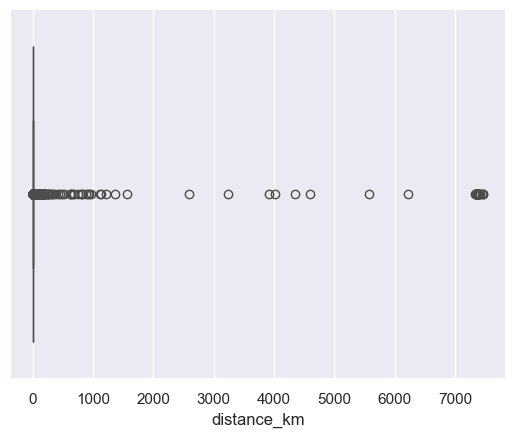

In [66]:
display(df_clear["distance_km"].describe(percentiles=[0.25, 0.75, 0.95, 0.99]))
sns.boxplot(df_clear, x="distance_km")
plt.show()

Посмотрим, что из себя представляют поездки больше 0.99 квантиля


In [67]:
df_clear[df_clear["distance_km"] > 26.907066].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,distance_km
count,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000,5974.000000
mean,-72.992798,40.044093,-73.117888,40.057295,1.789421,52.509782,2011.967359,6.395380,15.754101,13.612320,78.561857
std,9.401003,8.643206,9.118766,8.646214,1.339498,16.652627,1.864515,3.325022,8.717450,5.983936,545.856228
min,-77.738893,-74.008592,-97.166667,-74.177955,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,26.907089
25%,-73.980412,40.644924,-73.986163,40.645293,1.000000,49.570000,2010.000000,4.000000,8.000000,9.000000,27.462660
50%,-73.789952,40.648561,-73.961222,40.743930,1.000000,51.460000,2012.000000,6.000000,16.000000,15.000000,28.131498
75%,-73.782171,40.759601,-73.786123,40.765676,2.000000,57.330000,2014.000000,9.000000,23.000000,18.000000,29.436673
max,40.824302,64.866665,40.868997,49.433332,6.000000,237.430000,2015.000000,12.000000,31.000000,23.000000,7471.708288


Данные выглядят адекватно, кроме больших расстояний в 7к километров


Посмотрим на зависимость целевой переменной от расстояния


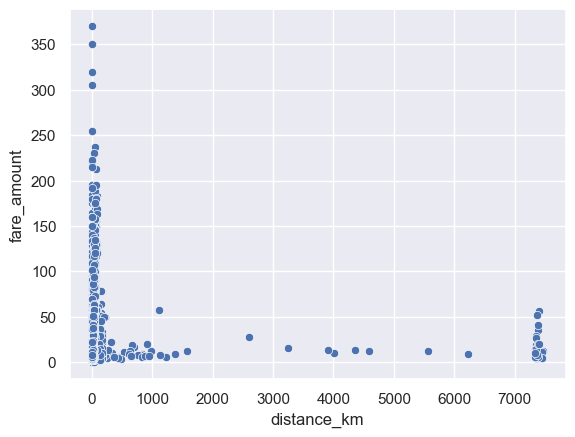

In [68]:
sns.scatterplot(data=df_clear, x="distance_km", y="fare_amount")
plt.show()

Можно заметить, что оплата поездки по расстояниям разбита на несколько кластеров, поделим данные и посмотрим на зависиомость целевой переменной


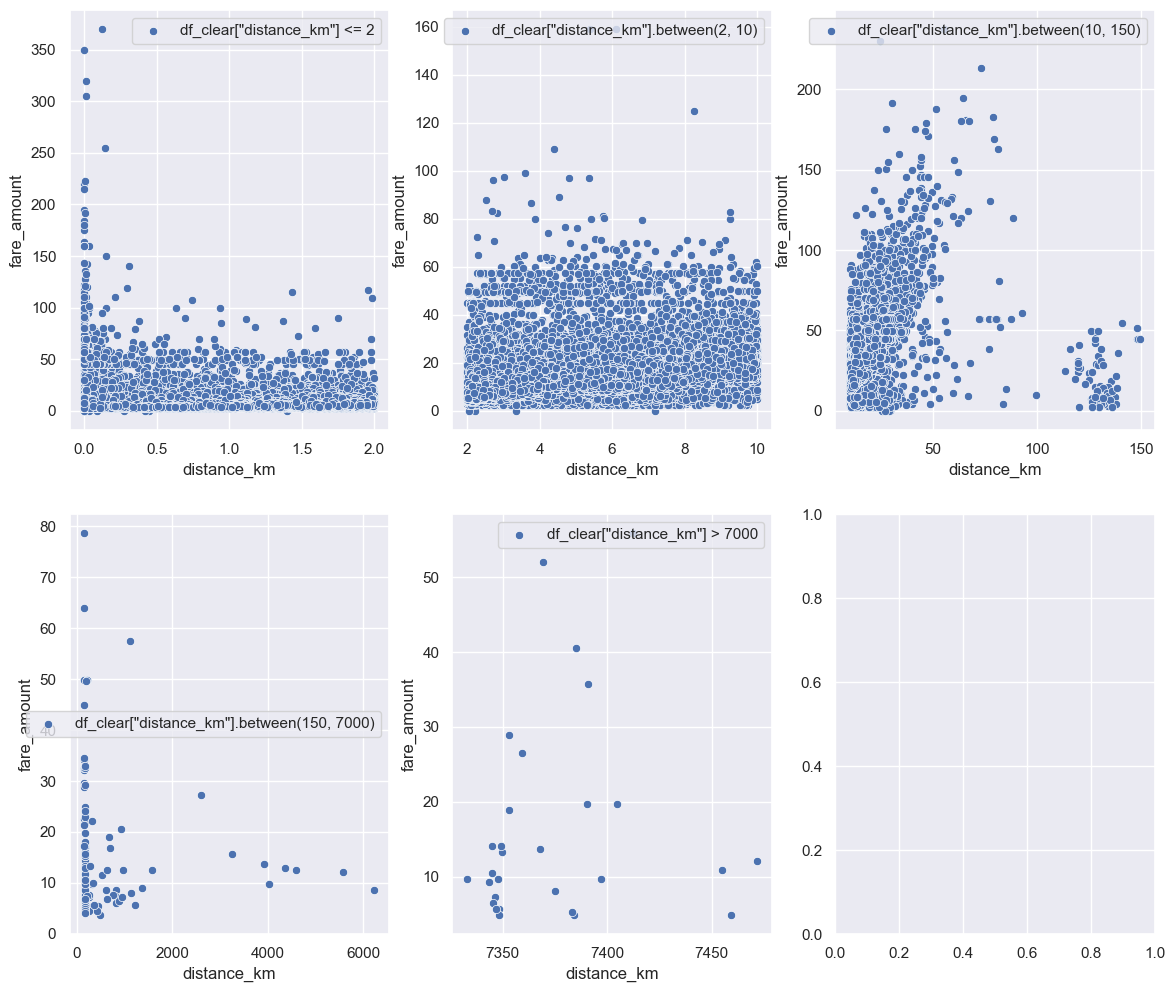

In [69]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 12))
sns.scatterplot(
    data=df_clear[df_clear["distance_km"] <= 2],
    x="distance_km",
    y="fare_amount",
    ax=axes[0][0],
    label='df_clear["distance_km"] <= 2',
)
sns.scatterplot(
    data=df_clear[df_clear["distance_km"].between(2, 10)],
    x="distance_km",
    y="fare_amount",
    ax=axes[0][1],
    label='df_clear["distance_km"].between(2, 10)',
)
sns.scatterplot(
    data=df_clear[df_clear["distance_km"].between(10, 150)],
    x="distance_km",
    y="fare_amount",
    ax=axes[0][2],
    label='df_clear["distance_km"].between(10, 150)',
)
sns.scatterplot(
    data=df_clear[df_clear["distance_km"].between(150, 7000)],
    x="distance_km",
    y="fare_amount",
    ax=axes[1][0],
    label='df_clear["distance_km"].between(150, 7000)',
)
sns.scatterplot(
    data=df_clear[df_clear["distance_km"] > 7000],
    x="distance_km",
    y="fare_amount",
    ax=axes[1][1],
    label='df_clear["distance_km"] > 7000',
)
plt.show()

Можно заметить линейную зависимость на расстояниях от 10 до 50-75 км, однако в остальных кластерах подобной завимости не наблюдается


### Обработка дат


Из данных по датам можно добавить новые признаки - выходные дни и праздники, однако стоит учитывать, что координаты относятся к Нью-Йорку, соотвественно нужно брать праздники и выходные, учитывая календарь США


In [ ]:
import holidays

us_calendar = holidays.USA()

date = df_clear["pickup_datetime"].dt.date.astype("datetime64[ns]")

is_holiday = date.map(us_calendar.get)
is_holiday = is_holiday.mask(is_holiday.notna(), True)
is_holiday = is_holiday.fillna(False)

df_clear["is_holiday"] = is_holiday

Проверим среднюю цену такси на праздники


In [71]:
df_clear.groupby(["is_holiday"])["fare_amount"].mean()

is_holiday
False    11.315705
True     11.401793
Name: fare_amount, dtype: float64

Средняя цена на поездку немного выше на праздники

Добавим признак выходного дня


In [72]:
df_clear["is_weekend"] = date.dt.day_of_week > 4
df_clear.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,distance_km,is_holiday,is_weekend
0,2011-11-23 15:00:00+00:00,-73.959075,40.783316,-73.959087,40.783345,1.0,2.5,2011,11,23,15,0.004468,False,False
1,2013-09-14 22:00:00+00:00,-73.931612,40.771060,-73.929097,40.760542,1.0,5.5,2013,9,14,22,1.571069,False,True
2,2012-04-30 18:00:00+00:00,-73.997929,40.740983,-74.007197,40.727725,2.0,6.5,2012,4,30,18,2.204098,False,False
3,2010-10-22 15:00:00+00:00,-73.980608,40.742449,-73.985609,40.755807,1.0,6.5,2010,10,22,15,2.040271,False,False
4,2011-02-18 18:00:00+00:00,-74.008884,40.720314,-73.983280,40.722350,1.0,12.1,2011,2,18,18,2.865870,False,False


Посмотрим на среднюю цену поездки в будние и выходные дни:


In [73]:
df_clear.groupby(["is_weekend"])["fare_amount"].mean()

is_weekend
False    11.338718
True     11.265170
Name: fare_amount, dtype: float64

Средняя цена поездки в будние дни немного выше


In [74]:
df_clear.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,year,month,day,hour,distance_km
count,597324.000000,597324.000000,597324.000000,597324.000000,597324.000000,597324.000000,597324.000000,597324.000000,597324.000000,597324.000000,597324.000000
mean,-73.920627,40.698268,-73.920611,40.698500,1.685109,11.317703,2011.743494,6.263381,15.705912,13.448612,4.924828
std,2.486976,2.457432,2.476027,2.457515,1.308969,9.609114,1.862997,3.435565,8.685148,6.678633,55.232286
min,-77.738893,-74.017510,-97.166667,-74.177955,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000111
25%,-73.992287,40.736610,-73.991560,40.735567,1.000000,6.000000,2010.000000,3.000000,8.000000,9.000000,1.691860
50%,-73.982106,40.753413,-73.980627,40.753930,1.000000,8.500000,2012.000000,6.000000,16.000000,14.000000,2.876268
75%,-73.968398,40.767602,-73.965453,40.768408,2.000000,12.500000,2013.000000,9.000000,23.000000,19.000000,5.208965
max,40.824302,64.866665,40.868997,49.433332,6.000000,370.000000,2015.000000,12.000000,31.000000,23.000000,7471.708288


## Cooking Models 🍳


Выделим обучающую выборку и таргет:


In [ ]:
X = df_clear.drop(["fare_amount", "pickup_datetime"], axis=1)
y = np.log1p(df_clear["fare_amount"])

Разделим данные на тестовую и тренировочные выборки


In [ ]:
df_clear.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'fare_amount', 'year', 'month', 'day', 'hour', 'distance_km',
       'is_holiday', 'is_weekend'],
      dtype='object')

In [ ]:
drop_columns = ["is_holiday", "is_weekend", "distance_km"]
X_train, X_test, y_train, y_test = train_test_split(
    X.drop(columns=drop_columns), y, test_size=0.25, random_state=42
)

In [ ]:
d3_model = DecisionTreeRegressor(max_depth=3, random_state=42)
d3_model.fit(X_train, y_train)
y_pred = d3_model.predict(X_test)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

NameError: name 'r2_expm1_score' is not defined

Результат модели с теми же гиперпараметрами но на очищенных данных, выше, чем у базовой модели без очистки данных (R2=0.44)
Проверим качество модели, с добавлением новых признаков


In [ ]:
X_train_new, X_test_new, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [ ]:
d3_model = DecisionTreeRegressor(max_depth=3, random_state=42)
d3_model.fit(X_train_new, y_train)
y_pred = d3_model.predict(X_test_new)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.74


Качество модели сильно выросло после добавления новых признаков, закодируем категориальные признаки методом, описанным в основной работе и проверим качество базовой модели


In [ ]:
X_train_new_cat = encode_categorial(X_train_new)
X_test_new_cat = encode_categorial(X_test_new)

In [ ]:
d3_model = DecisionTreeRegressor(max_depth=3, random_state=42)
d3_model.fit(X_train_new_cat, y_train)
y_pred = d3_model.predict(X_test_new_cat)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.74


Качество модели осталось прежним, несмотря на кодирование категориальных признаков, попробуем метод кодирования, основанный на TargetEncoding


In [ ]:
cat_columns = ["year", "month", "day", "hour"]

p1 = Pipeline(
    [
        ("encoder", TargetEncoder(cols=cat_columns, return_df=True)),
        ("scaler", StandardScaler().set_output(transform="pandas")),
        ("model", DecisionTreeRegressor(max_depth=3, random_state=42)),
    ]
)

p1.fit(X_train_new, y_train)
y_pred = p1.predict(X_test_new)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.74


Использование TargetEncoding на данных без кодирования не повысило качество оценки, добавим степени к нашим признакам


In [ ]:
cat_columns = ["year", "month", "day", "hour"]

In [ ]:
p2 = Pipeline(
    [
        ("encoder", TargetEncoder(cols=cat_columns, return_df=True)),
        ("feature_poly", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler().set_output(transform="pandas")),
        ("model", DecisionTreeRegressor(max_depth=3, random_state=42)),
    ]
)

p2.fit(X_train_new, y_train)
y_pred = p2.predict(X_test_new)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.75


Качество удалось повысить на один пункт, проверим пайплайн, используя наше кодирование


In [ ]:
p3 = Pipeline(
    [
        ("feature_poly", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler().set_output(transform="pandas")),
        ("model", DecisionTreeRegressor(max_depth=3, random_state=42)),
    ]
)

p3.fit(X_train_new_cat, y_train)
y_pred = p3.predict(X_test_new_cat)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.74


Качество улучшить не удалось, подберём гиперпараметры для нашей модели c помощью Optuna


In [ ]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_train_new, y_train, test_size=0.25, random_state=42
)

data_prep_pipeline = Pipeline(
    [
        ("encoder", TargetEncoder(cols=cat_columns, return_df=True)),
        ("feature_poly", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler().set_output(transform="pandas")),
        # ("reducer", SelectFromModel(Ridge())),
    ]
)

X_train_sub = data_prep_pipeline.fit_transform(X_train_sub, y_train_sub)
X_test_sub = data_prep_pipeline.transform(X_test_sub)

In [ ]:
import optuna


def objective_p4(trial: optuna.Trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        # "criterion": trial.suggest_categorical(
        #     "criterion", ["squared_error", "friedman_mse", "absolute_error"]
        # ),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
    }

    model = DecisionTreeRegressor(**params, random_state=42)
    model.fit(X_train_sub, y_train_sub)
    return r2_expm1_score(y_test_sub, model.predict(X_test_sub))

    # return cross_val_score(p4, X_train_new, y_train, cv=3).mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective_p4, n_trials=20, n_jobs=-1)

[I 2024-10-25 23:42:02,502] A new study created in memory with name: no-name-c1d8577f-5acd-450c-8ea7-cfd306f30742
[I 2024-10-25 23:42:02,772] Trial 1 finished with value: 0.5751058011505749 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5751058011505749.
[I 2024-10-25 23:42:02,805] Trial 4 finished with value: 0.5380308313630647 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.5751058011505749.
[I 2024-10-25 23:42:02,874] Trial 6 finished with value: 0.5348279197215802 and parameters: {'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.5751058011505749.
[I 2024-10-25 23:42:02,952] Trial 0 finished with value: 0.7043783716831765 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 

In [ ]:
best_params = {
    "max_depth": 14,
    "min_samples_split": 7,
    "min_samples_leaf": 6,
    "max_features": "log2",
}

In [ ]:
p4 = Pipeline(
    [
        # ("data_prep", data_prep_pipeline),
        ("model", DecisionTreeRegressor(**best_params, random_state=42)),
    ]
)

p4.fit(X_train_new, y_train)
y_pred = p4.predict(X_test_new)

print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.81


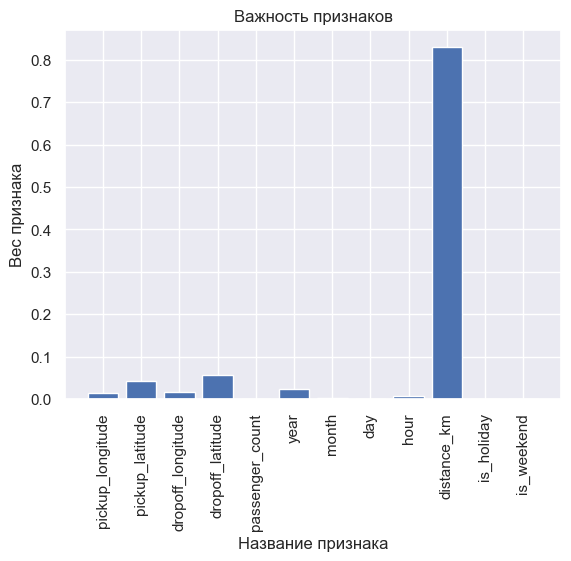

In [ ]:
plt.bar(X_train_new.columns, p4.steps[-1][1].feature_importances_)
plt.xticks(rotation=90)
plt.xlabel("Название признака")
plt.ylabel("Вес признака")
plt.title("Важность признаков")
plt.show()

### Booooooooooostingss OYAAAAYA


Используем LightGBM с дефолтными гиперпараметрами на данных без кодирования и новых признаков


In [ ]:
import lightgbm

lightgbm_model = lightgbm.LGBMRegressor(n_jobs=-1)
lightgbm_model.fit(X_train, y_train)

y_pred = lightgbm_model.predict(X_test)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 447993, number of used features: 9
[LightGBM] [Info] Start training from score 2.333738
R2: 0.81


Существенная разница, используя бустинг с дефолтными параметрами, проверим на данных с новыми признаками


In [ ]:
lightgbm_model = lightgbm.LGBMRegressor(n_jobs=-1)
lightgbm_model.fit(X_train_new, y_train)

y_pred = lightgbm_model.predict(X_test_new)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 447993, number of used features: 12
[LightGBM] [Info] Start training from score 2.333738
R2: 0.84


Существенного прироста не произошло, проверим с кодированием из курса


In [ ]:
lightgbm_model = lightgbm.LGBMRegressor(n_jobs=-1)
lightgbm_model.fit(X_train_new_cat, y_train)

y_pred = lightgbm_model.predict(X_test_new_cat)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1316
[LightGBM] [Info] Number of data points in the train set: 447993, number of used features: 20
[LightGBM] [Info] Start training from score 2.333738
R2: 0.84


Качество модели не стало выше, используем TargetEncoding


In [ ]:
p5 = Pipeline(
    [
        ("encoder", TargetEncoder(cols=cat_columns, return_df=True)),
        ("model", lightgbm.LGBMRegressor(n_jobs=-1)),
    ]
)
p5.fit(X_train_new, y_train)

y_pred = p5.predict(X_test_new)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 447993, number of used features: 12
[LightGBM] [Info] Start training from score 2.333738
R2: 0.84


Кодирование с помощью TargetEncoding не помогло, обработаем данные с помощью пайлана с нормализацией и добавлением полиномиальный признаков


In [ ]:
p6 = Pipeline(
    [("data_prep", data_prep_pipeline), ("model", lightgbm.LGBMRegressor(n_jobs=-1))]
)
p6.fit(X_train_new, y_train)

y_pred = p6.predict(X_test_new)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.85


Добавление полиномиальных признаков немного увеличило качество, подберём гиперпараметры:


In [ ]:
def objective_lightgbm(trial: optuna.Trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 250),
        "n_leaves": trial.suggest_int("n_leaves", 15, 75),
        "max_depth": trial.suggest_int("max_depth", 2, 14),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2, step=0.01),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
    }

    model = lightgbm.LGBMRegressor(**params, n_jobs=-1, verbose=-1)
    model.fit(X_train_sub, y_train_sub)
    return r2_expm1_score(y_test_sub, model.predict(X_test_sub))


study = optuna.create_study(direction="maximize")
study.optimize(objective_lightgbm, n_trials=200, n_jobs=-1)

[I 2024-10-26 00:28:15,931] A new study created in memory with name: no-name-67dbcb38-d9f3-4c25-8384-cb5455d59a25
[I 2024-10-26 00:28:23,491] Trial 7 finished with value: 0.8195827101055471 and parameters: {'n_estimators': 124, 'n_leaves': 43, 'max_depth': 2, 'learning_rate': 0.55, 'min_child_samples': 7}. Best is trial 7 with value: 0.8195827101055471.
[I 2024-10-26 00:28:26,767] Trial 4 finished with value: 0.8236063011354259 and parameters: {'n_estimators': 213, 'n_leaves': 36, 'max_depth': 2, 'learning_rate': 0.55, 'min_child_samples': 29}. Best is trial 4 with value: 0.8236063011354259.
[I 2024-10-26 00:28:27,218] Trial 1 finished with value: 0.8322363617675799 and parameters: {'n_estimators': 174, 'n_leaves': 74, 'max_depth': 3, 'learning_rate': 0.25, 'min_child_samples': 23}. Best is trial 1 with value: 0.8322363617675799.
[I 2024-10-26 00:28:27,357] Trial 3 finished with value: 0.8137354690122359 and parameters: {'n_estimators': 223, 'n_leaves': 54, 'max_depth': 2, 'learning_ra

In [ ]:
print(study.best_params)

{'n_estimators': 176, 'n_leaves': 41, 'max_depth': 11, 'learning_rate': 0.15000000000000002, 'min_child_samples': 27}


In [ ]:
p7 = Pipeline(
    [
        ("data_prep", data_prep_pipeline),
        ("model", lightgbm.LGBMRegressor(**study.best_params, n_jobs=-1, verbose=-1)),
    ]
)
p7.fit(X_train_new, y_train)

y_pred = p7.predict(X_test_new)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.86


Посмотрим на важность признаков модели


In [ ]:
p7.steps[1][1].feature_importances_

array([  0, 136,  88, 207,  96,   0,  10,  22,  29, 142, 105,   0,   0,
       123, 340, 254, 177,  39,  43,  43,  45,  75,  92,   0,  24,  47,
       170, 184,  31,  58,  35,  49,  66,  36,   2,  25, 145, 373,  37,
        44,  41,  39,  89,  23,   1,  34, 101,  29,  49,  33,  37,  89,
        29,  11,  46,   0,  25,  20,  29,  43, 116,   0,   1,   0, 142,
        51,  70, 227,   5,   5,   0,  68,  71,  56,   8,  13,   0,  50,
        21,   1,  10,   0,  61,   9,  32,  28,  17,  58,   0,   0,   0],
      dtype=int32)

Опробуем CatBoost, для начала не будем использовать кодирование категориальных признаков


R2: 0.86


Катбуст с дефолтными гиперпарамтрами отдал качество равное LightGBM с оптимизацией, добавим кодирование категориальных признаков


In [ ]:
catboost_model = catboost.CatBoostRegressor(verbose=0)
catboost_model.fit(X_train_new, y_train, cat_features=cat_columns)

y_pred = catboost_model.predict(X_test_new)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.85


Кодирование категориальных признаков не дало повышение качества, добавим категориальные признаки с помощью метода ранее, но не будем делать OneHotEncoding, оставим кодироавание CatBoost'у


In [ ]:
X_train_new_cat = encode_categorial(X_train_new, False)
X_test_new_cat = encode_categorial(X_test_new, False)

catboost_model = catboost.CatBoostRegressor(verbose=0)
catboost_model.fit(
    X_train_new_cat, y_train, cat_features=["season", "month_part", "day_part"]
)

y_pred = catboost_model.predict(X_test_new_cat)
print("R2:", round(r2_expm1_score(y_test, y_pred), 2))

R2: 0.85


Кодирование признаков из курса не дало повышение качества, попробуем добавить полиномиальных признаков


In [ ]:
p8 = Pipeline(
    [
        ("data_prep", data_prep_pipeline),
        ("model", catboost.CatBoostRegressor(thread_count=-1, verbose=0)),
    ]
)

p8.fit(X_train_new, y_train)
y_pred = p8.predict(X_test_new)
print("R2:", r2_expm1_score(y_test, y_pred))

R2: 0.855146173086494


Использование полиномиальных признаков не дало сильного повышения качества, подберём гиперпараметры


In [ ]:
X_train_new_prep = data_prep_pipeline.fit_transform(X_train_new, y_train)
X_test_new_prep = data_prep_pipeline.transform(X_test_new)


def objective_catboost(trial: optuna.Trial):
    params = {
        "iterations": trial.suggest_int("n_estimators", 1000, 1500),
        "depth": trial.suggest_int("depth", 6, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.15, 0.2, step=0.05),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0, 5, step=0.5),
    }

    model = catboost.CatBoostRegressor(
        **params, thread_count=-1, verbose=0, task_type="GPU"
    )
    model.fit(X_train_new_prep, y_train)
    return r2_expm1_score(y_test, model.predict(X_test_new_prep))


study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)

[I 2024-11-13 19:14:26,140] A new study created in memory with name: no-name-e33ffc62-2bd9-43df-98f4-d11f9d1864b4
[I 2024-11-13 19:15:06,462] Trial 0 finished with value: 0.8541601647328706 and parameters: {'n_estimators': 1397, 'depth': 10, 'learning_rate': 0.15, 'l2_leaf_reg': 1.0}. Best is trial 0 with value: 0.8541601647328706.
[I 2024-11-13 19:15:23,472] Trial 1 finished with value: 0.8543047170950762 and parameters: {'n_estimators': 1246, 'depth': 7, 'learning_rate': 0.2, 'l2_leaf_reg': 0.0}. Best is trial 1 with value: 0.8543047170950762.
[I 2024-11-13 19:15:41,867] Trial 2 finished with value: 0.8569705829159283 and parameters: {'n_estimators': 1482, 'depth': 6, 'learning_rate': 0.15, 'l2_leaf_reg': 0.5}. Best is trial 2 with value: 0.8569705829159283.
[I 2024-11-13 19:16:20,667] Trial 3 finished with value: 0.8522511410542669 and parameters: {'n_estimators': 1077, 'depth': 11, 'learning_rate': 0.2, 'l2_leaf_reg': 2.5}. Best is trial 2 with value: 0.8569705829159283.
[I 2024-11

In [ ]:
print(study.best_params)

{'n_estimators': 1278, 'depth': 9, 'learning_rate': 0.15, 'l2_leaf_reg': 3.0}


In [ ]:
best_params = {
    "n_estimators": 1278,
    "depth": 9,
    "learning_rate": 0.15,
    "l2_leaf_reg": 3.0,
}
p9 = Pipeline(
    [
        ("data_prep", data_prep_pipeline),
        (
            "model",
            catboost.CatBoostRegressor(
                **best_params,
                thread_count=-1,
                verbose=0,
            ),
        ),
    ]
)

p9.fit(X_train_new, y_train)
y_pred = p9.predict(X_test_new)
print("R2:", r2_expm1_score(y_test, y_pred))

R2: 0.86156367835126


## Подготовка к развёртыванию


Напишем пайплайн на основе нашей обработки и лучшей модели p9, который будет очищать входные данные и обучать модель

1. Проверяем, что наши данные без выбросов - это на стороне API
2. На вход поступают: дата и время поездки, координаты точки отправления, координаты места назначения, кол-во пассажиров
3. Обрабатываем данные, получаем новые признаки
4. Обучаем модель на параметрах выдающих наилучшее качество


In [52]:
from datetime import datetime

from pydantic import BaseModel, field_validator, model_validator


class TaxiTravel(BaseModel):
    """
    Модель данных описывающих поездку
    """

    pickup_datetime: datetime
    pickup_latitude: float
    pickup_longitude: float
    dropoff_latitude: float
    dropoff_longitude: float
    passenger_count: float

    @field_validator("passenger_count")
    @classmethod
    def validate_passengers(cls, v: float) -> str:
        if not (1 <= v <= 8):
            raise ValueError(
                "Количество пассажиров не может быть меньше 1 и не может превышать 8"
            )

        return v

    @field_validator("pickup_latitude", "dropoff_latitude")
    @classmethod
    def validate_latitude(cls, v: float) -> str:
        if not (-90 <= v <= 90):
            raise ValueError("Широта должна быть в пределах [-90, 90]")

        return v

    @field_validator("pickup_longitude", "dropoff_longitude")
    @classmethod
    def validate_longitude(cls, v: float) -> str:
        if not (-180 <= v <= 180):
            raise ValueError("Долгота должна быть в пределах [-180, 180]")

        return v

    @model_validator(mode="after")
    def validate_same_coords(self) -> "TaxiTravel":
        if (
            abs(self.pickup_latitude - self.dropoff_latitude) <= 1e-5
            and abs(self.pickup_longitude - self.dropoff_longitude) <= 1e-5
        ):
            raise ValueError(
                "Точка назначения та же, что и точка отправления, измените координаты"
            )

        return self

    def model_dump_df(self) -> pd.DataFrame:
        return pd.DataFrame([self.model_dump(mode="python")])

In [53]:
TaxiTravel(
    pickup_datetime=datetime(2014, 1, 1, 1, 1, 1),
    pickup_latitude=21,
    pickup_longitude=90,
    dropoff_latitude=90,
    dropoff_longitude=88,
    passenger_count=2,
).model_dump_df()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2014-01-01 01:01:01,21.0,90.0,90.0,88.0,2.0


In [13]:
from pydantic import ValidationError

try:
    TaxiTravel(
        pickup_datetime=datetime(2014, 1, 1, 1, 1, 1),
        pickup_latitude=90,
        pickup_longitude=90,
        dropoff_latitude=90,
        dropoff_longitude=90,
        passenger_count=2,
    )
except ValidationError as e:
    for err in e.errors():
        print(err.get("ctx", {}).get("error"))
    pass

Точка назначения та же, что и точка отправления, измените координаты


In [ ]:
from typing import Callable

import holidays
from pyproj import Transformer
from sklearn.base import TransformerMixin


def euclidian_distance(x1: pd.Series, x2: pd.Series, y1: pd.Series, y2: pd.Series):
    """
    Евклидово расстояние между двумя точками
    требует преобразования градусной системы координат в метрическую
    """
    return np.sqrt((y1 - x1) ** 2 + (y2 - x2) ** 2)


def calculate_distance(
    x1: pd.Series,
    x2: pd.Series,
    y1: pd.Series,
    y2: pd.Series,
    dist_func: Callable[[pd.Series, pd.Series, pd.Series, pd.Series], pd.Series],
    transformer: Transformer | None = None,
):
    if transformer:
        x1, x2 = transformer.transform(x1, x2)
        y1, y2 = transformer.transform(y1, y2)

    return dist_func(x1, x2, y1, y2)


class FeatureEngineering(TransformerMixin):
    def __init__(
        self,
        copy_x: bool = True,
        distance_func: Callable[
            [pd.Series, pd.Series, pd.Series, pd.Series], pd.Series
        ] = euclidian_distance,
    ):
        self.copy_x = copy_x
        self.distance_func = distance_func

    def fit(self, X: pd.DataFrame | None = None, y=None) -> "FeatureEngineering":
        return self

    def _add_distance(self, X: pd.DataFrame):
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

        x1 = X["pickup_latitude"]
        x2 = X["pickup_longitude"]
        y1 = X["dropoff_latitude"]
        y2 = X["dropoff_longitude"]

        X.loc[:, "distance_km"] = (
            calculate_distance(
                x1, x2, y1, y2, self.distance_func, transformer=transformer
            )
            / 1000
        )

        return X

    def _prepare_datetime(self, X: pd.DataFrame) -> pd.DataFrame:
        date = X["pickup_datetime"].dt.date.astype("datetime64[ns]")

        X["year"] = date.dt.year
        X["month"] = date.dt.month
        X["day"] = date.dt.day
        X["hour"] = date.dt.hour

        us_calendar = holidays.USA()

        is_holiday = date.map(us_calendar.get)
        is_holiday = is_holiday.mask(is_holiday.notna(), True)
        is_holiday = is_holiday.fillna(False)

        X["is_holiday"] = is_holiday

        X["is_weekend"] = date.dt.day_of_week > 4

        X = X.drop("pickup_datetime", axis=1)

        return X

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        if self.copy_x:
            X = X.copy()

        X = self._add_distance(X)
        X = self._prepare_datetime(X)

        return X

In [15]:
import pandas as pd

In [25]:
TaxiTravel(
    pickup_datetime=datetime(2014, 1, 1, 1, 1, 1),
    pickup_latitude=90,
    pickup_longitude=91,
    dropoff_latitude=90,
    dropoff_longitude=90,
    passenger_count=2,
).model_dump()

{'pickup_datetime': datetime.datetime(2014, 1, 1, 1, 1, 1),
 'pickup_latitude': 90.0,
 'pickup_longitude': 91.0,
 'dropoff_latitude': 90.0,
 'dropoff_longitude': 90.0,
 'passenger_count': 2.0}

In [60]:
import joblib

MODELS_DIR = PROJECT_DIR / "models"

In [ ]:
def save_model(*, model_type: str, version: int, model_obj):
    id_ = len(list(MODELS_DIR.iterdir()))

    model_name = f"{id_}_{model_type}_v_{version}.joblib"
    model_path = MODELS_DIR / model_name

    if model_path.exists():
        raise ValueError("Поменяйте версию модели или её тип")

    model_name = f"{id_ + 1}_{model_type}_v_{version}.joblib"
    model_path = MODELS_DIR / model_name

    joblib.dump(model_obj, model_path)

In [ ]:
save_model(model_type="catboost", version=1, model_obj=p9)

In [64]:
def load_model(models_dir: Path) -> Pipeline:
    model_path = sorted(list(models_dir.iterdir()), reverse=True)[0]
    model = joblib.load(model_path)
    return model